Generate a simple three-atom MD simluation with a single "bond breaking" barrier that can be crossed.

Propogated with the (frictionless) Langevin equation:
$$
\frac{dx}{dt} = - \frac{\nabla V(x)}{kT} + \sqrt{2 D} R(t)
$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# MODEL PARAMETERS
# all units reduced
# in school, units never mattered anyways

# spring constants
k12 = 1.0
k13 = 1.0
k23 = 1.0

# radii
r12 = 1.0
r13 = 1.0
r23 = 1.0

# "special" parameters
c13 = 1.3  # bond break dist
c23 = 1.25 # bond shift dist

# Langevin
D  = 1.0
kT = 1.0


norm = lambda d : np.sqrt(np.sum(np.square(d), axis=-1))
unit = lambda vec : vec / r(vec)


def V(x):
    e12 = - 0.5 * k12 * np.square( norm(x[0,:] - x[1,:]) - r12 )
    e13 = - 0.5 * k13 * np.square( norm(x[0,:] - x[2,:]) - r13 )
    e23 = - 0.5 * k23 * np.square( norm(x[1,:] - x[2,:]) - r23 )
    return e12 + e13 + e23


def dV(x):
    """ dV[i,j] = force on atom i in direction j"""
    
    n = x.shape[0]
    dists = np.zeros((n,n))
    dirs  = np.zeros((n,n,3))
    
    for i in range(n):
        for j in range(i,n):
            dists[i,j] = norm(x[i] - x[j])
            dists[j,i] = dists[i,j]
            dirs[i,j,:] = np.nan_to_num( (x[i] - x[j]) / dists[i,j] )
            dirs[j,i,:] = np.nan_to_num( -dirs[i,j,:]  / dists[j,i] )
    
    if dists[0,2] > c13:
        r13 = 1.0
        k13 = 0.0
    else:
        r13 = 1.0
        k13 = 1.0
    
    if dists[1,2] > c23:
        r23 = 1.5
        k23 = 0.75
    else:
        r23 = 1.0
        k23 = 1.0
            
    Kij = np.array([[0.0, k12, k13],
                    [k12, 0.0, k23],
                    [k13, k23, 0.0]])
    
    dist0 = np.array([[0.0, r12, r13],
                      [r12, 0.0, r23],
                      [r13, r23, 0.0]])

    F = - np.sum( dirs * (Kij * (dists - dist0))[:,:,None], axis=0)
    assert F.shape == (3,3)
    return F


def velo(x):
    R = np.random.randn(3,3)
    v = - dV(x) / kT + np.sqrt(2 * D) * R
    return v

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


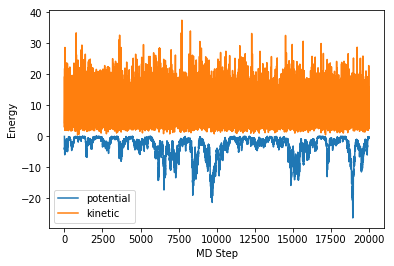

In [3]:
# RUN A TRAJECTORY
n_steps     = 20000
n_min_steps = 0
dt          = 0.02

# positions & velocities
# steps / particles / {xyz}
x = np.zeros((n_steps, 3, 3))
v = np.zeros((n_steps, 3, 3))

x[0] = np.array([[1.0, 0.0, 0.0],
                 [0.0, 1.0, 0.0],
                 [0.0, 0.0, 1.0]])
v[0] = np.sqrt(2 * D) * np.random.randn(3,3)

# energy
E = np.zeros(n_steps)

# energy min
for i in range(n_min_steps):
    x[0] = x[0] - dV(x[0]) * dt * 0.1

# Euler
for i in range(1, n_steps):
    x[i]  = x[i-1] + v[i-1] * dt
    x[i] -= np.mean(x[i,:,:], axis=0) # CoM removal
    v[i]  = velo(x[i])
    E[i]  = V(x[i])
    
plt.figure()
plt.plot(np.arange(n_steps), 10 * E)
plt.plot(np.arange(n_steps), 0.5 * np.square(v).sum(2).sum(1))
plt.xlabel('MD Step')
plt.ylabel('Energy')
plt.legend(['potential', 'kinetic'])
plt.show()

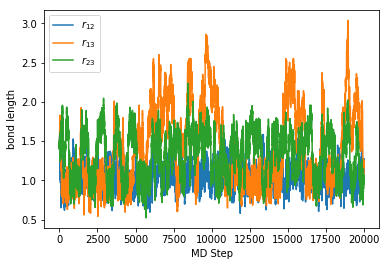

In [4]:
def compute_radii(xyz):
    """
    convert a trajectory in x/y/z in to distances: r12, r13, r23
    """
    r12 = norm(x[:,0] - x[:,1])
    r13 = norm(x[:,0] - x[:,2])
    r23 = norm(x[:,1] - x[:,2])
    return np.array([r12, r13, r23])

r = compute_radii(x)

plt.figure()
plt.plot( r[0] )
plt.plot( r[1] )
plt.plot( r[2] )
plt.legend(['$r_{12}$', '$r_{13}$', '$r_{23}$'])
plt.xlabel('MD Step')
plt.ylabel('bond length')
plt.show()

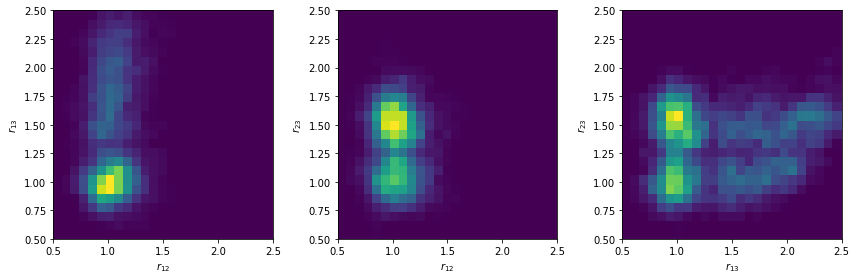

In [5]:
# plot the free energy in the radii space
limits = [[0.5,2.5],[0.5,2.5]]

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.hist2d(r[0], r[1], bins=25, range=limits)
plt.xlabel('$r_{12}$')
plt.ylabel('$r_{13}$')

plt.subplot(132)
plt.hist2d(r[0], r[2], bins=25, range=limits)
plt.xlabel('$r_{12}$')
plt.ylabel('$r_{23}$')

plt.subplot(133)
plt.hist2d(r[1], r[2], bins=25, range=limits)
plt.xlabel('$r_{13}$')
plt.ylabel('$r_{23}$')

plt.tight_layout()

plt.show()

In [6]:
# optional step: export to a standard format
# so we can e.g. visualize in VMD
import mdtraj as md

top  = md.load('triatom.pdb').topology
traj = md.Trajectory(x, top)

In [7]:
# lets place Gaussian blobs on the atoms to make a 3d trajectory

def atomic_electrondens(r_mag, radial_cutoff=None, A=1.0, sigma=0.1):

    phi = np.zeros_like(r_mag)
    
    if radial_cutoff is not None:
        inds = (r_mag < radial_cutoff)
        if np.sum(inds) == 0:
            raise ValueError('No grid points contained in radial cutoff!')
    else:
        inds = np.ones(r_mag.shape, dtype=np.bool)    

    phi[inds] = A * np.exp( - np.square(r_mag[inds]) / (2.0 * sigma) )

    return phi


def atomic_to_density(xyz, grid_dimensions, grid_spacing, atom_amp_sigmas, radial_cutoff=3.0):
    """
    Evaluate the electron density on a rectangular grid given an atomic model.
    Uses and atom-centered Gaussian model.
    
    Parameters
    ----------
    xyz : np.ndarray
        An atomic structure.
        
    grid_dimensions : tuple
        A 3-tuple indicating how many grid points to employ in each dimension 
        (xyz).

    grid_spacing : float
        The distance between grid points, in Angstroms.
        
    Optional Parameters
    -------------------
    radial_cutoff : float
        A cutoff for the size of the Gaussian calculation. Can result in a
        significant speedup for large grids at the cost of a very small error.

    Returns
    -------
    grid : np.ndarray, float
        A 3-dimensional array, representing the electron density (scalar field)
        sampled at each point on the grid.
    """
    
    grid_dimensions = tuple(grid_dimensions)

    grid = np.zeros(grid_dimensions)
    center = np.array(grid_dimensions) / 2.0 + np.array([0.5, 0.5, 0.5])
    nxyz = np.mgrid[:grid_dimensions[0],
                    :grid_dimensions[1],
                    :grid_dimensions[2]].astype(np.float) - center[:,None,None,None]
    nxyz *= grid_spacing

    for i in range(xyz.shape[0]): # loop over atoms
        r = xyz[i,:]
        r_mag = np.sqrt(np.sum( np.square(nxyz - r[:,None,None,None]), axis=0 ))
        assert r_mag.shape == grid_dimensions, '%s / %s' % (str(r_mag.shape), str(grid_dimensions))
        
        grid += atomic_electrondens(r_mag, radial_cutoff=radial_cutoff,
                                    A=atom_amp_sigmas[i][0],
                                    sigma=atom_amp_sigmas[i][1])

    return grid

In [8]:
grid_dimensions  = (32, 32, 32)
grid_spacing     = 0.1
atom_amp_sigmas  = [(1.0, 0.1), 
                    (0.8, 0.1), 
                    (1.0, 0.05)]

density = atomic_to_density(x[700], grid_dimensions, grid_spacing, atom_amp_sigmas, radial_cutoff=3.0)

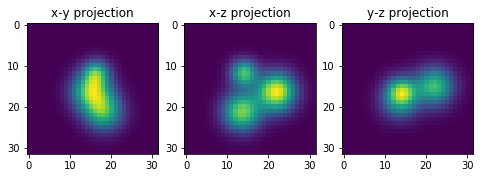

In [9]:
plt.figure(figsize=(8,4))

plt.subplot(131)
plt.title('x-y projection')
plt.imshow(density.mean(2))

plt.subplot(132)
plt.title('x-z projection')
plt.imshow(density.mean(1))

plt.subplot(133)
plt.title('y-z projection')
plt.imshow(density.mean(0))

plt.show()

In [26]:
def rand_rot(rands = None):
    """
    Compute a uniform, random rotation matrix. 
    
    Optional Parameters
    ------------------
    rands : np.ndarray, float, shape( 3,)
        3 random numbers used to define matrix

    Returns
    -------
    RU : np.matrix, float
        A 3x3 matrix defining a uniform, random rotation.
    
    Reference
    ---------
    ..[1] http://www.google.com/url?sa=t&rct=j&q=uniform%20random%20rotation%20matrix&source=web&cd=5&ved=0CE8QFjAE&url=http%3A%2F%2Fciteseerx.ist.psu.edu%2Fviewdoc%2Fdownload%3Fdoi%3D10.1.1.53.1357%26rep%3Drep1%26type%3Dps&ei=lw2cUa2eIMKRiQKXnIDwBQ&usg=AFQjCNHViFXwwa8kv_tobzteWYM8EaKF-w&sig2=148RpesMoZvJmtse2oerjg&bvm=bv.46751780,d.cGE
    """
    
    # 3 random numbers
    np.random.seed()
    if rands == None:
        rands = np.random.random(( 3, ) )

    x1 = rands[0] * np.pi * 2
    x2 = rands[1] * np.pi * 2
    x3 = rands[2]

    # matrix for rotation about z-axis
    Rz1 = [ np.cos(x1), np.sin(x1), 0]
    Rz2 = [-np.sin(x1), np.cos(x1), 0]
    Rz = np.matrix(  [ Rz1, Rz2, [ 0, 0, 1 ] ]  )


    # matrix for rotating the pole
    v = np.array( [ np.cos(x2) * np.sqrt(x3) ,
                    np.sin(x2) * np.sqrt(x3) ,
                    np.sqrt( 1 - x3 ) ] )
    H  = np.identity( 3 ) - 2 * np.outer(v,v)
    RU = -H*Rz
    return np.array(RU)

In [30]:
# randomly rotate and translate
translated_x = x + np.random.randn(3)
rotated_x = np.dot(translated_x, rand_rot())

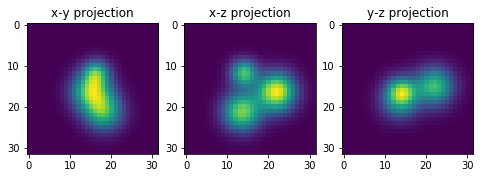

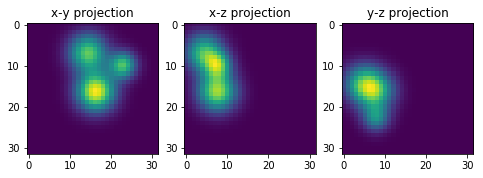

In [31]:
density = atomic_to_density(x[700], grid_dimensions, grid_spacing, atom_amp_sigmas, radial_cutoff=3.0)

plt.figure(figsize=(8,4))

plt.subplot(131)
plt.title('x-y projection')
plt.imshow(density.mean(2))

plt.subplot(132)
plt.title('x-z projection')
plt.imshow(density.mean(1))

plt.subplot(133)
plt.title('y-z projection')
plt.imshow(density.mean(0))

plt.show()

density = atomic_to_density(rotated_x[700], grid_dimensions, grid_spacing, atom_amp_sigmas, radial_cutoff=3.0)

plt.figure(figsize=(8,4))

plt.subplot(131)
plt.title('x-y projection')
plt.imshow(density.mean(2))

plt.subplot(132)
plt.title('x-z projection')
plt.imshow(density.mean(1))

plt.subplot(133)
plt.title('y-z projection')
plt.imshow(density.mean(0))

plt.show()